In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
import matplotlib.pyplot as plt

# --- Configuration ---
CSV_PATH = "rates.csv"
BATCH_SIZE = 32
LEARNING_RATE = 0.001
TEST_SPLIT = 0.2

# Train NN for model surrogate
Here I train a NN for predicting the reaction rate of N2O given T,xNH3, xNO, xO2. 
Several different studies are performed.
- Effect of input scaling (standardization)
- Error study:
    - Vary number of layers and neurons per layers
    - Varying activation functions
- We test the ability of the network to extrapolate reaction rates from lower temperatures to higher temperatures
- Conclusions: I can replicate the results from my dissertation and it shows that NN are a promising alternative for surrogate modeling.

As a note we clip the gradients to 1 for stability

In [28]:
class ReactionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.FloatTensor(y.values).unsqueeze(1)  
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
class SurrogateModel(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 64], activation='ReLU'):
        """
        Args:
            input_dim: Number of input features
            hidden_dims: List of hidden layer dimensions (e.g., [128, 64, 32])
            activation: Activation function name ('ReLU', 'Tanh', 'LeakyReLU')
        """
        super().__init__()
        
        # Map string to activation class
        activations = {
            'ReLU': nn.ReLU,
            'Tanh': nn.Tanh,
            'Sigmoid': nn.Sigmoid,
            'LeakyReLU': nn.LeakyReLU,
            'SiLU': nn.SiLU
        }
        self.act_fn = activations.get(activation, nn.ReLU)
        
        # Build layers dynamically
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                self.act_fn()
            ])
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)
    

def train_model(model, train_loader, val_loader, learning_rate=LEARNING_RATE):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses, val_losses = [], []
    
    for epoch in range(EPOCHS):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                val_predictions = model(X_val).squeeze()
                val_loss += criterion(val_predictions, y_val.squeeze()).item()
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {train_loss/len(train_loader):.6f}, Val Loss: {val_loss/len(val_loader):.6f}")
        
        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
    
    return train_losses, val_losses

In [3]:
def plot_results(train_losses, val_losses, predictions):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.title('Training History')

    plt.subplot(1, 2, 2)
    plt.scatter(y_val, predictions, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Model Performance')
    plt.tight_layout()
    plt.show()


In [ ]:
def load_data2(scaling=True, random_state=1):
    df = pd.read_csv(CSV_PATH)
    df = df[['T', 'xNH3', 'xO2', 'xNO', 'rN2O']]
    df = df.sample(10000, random_state=1)

    # Transform and split features and target
    target_col = 'rN2O'
    df[target_col] = np.log(df[target_col])
    df['T'] = 1/df['T']
    df['xNH3'] = np.log(df['xNH3'])
    df['xO2'] = np.log(df['xO2'])
    df['xNO'] = np.log(df['xNO'])

    from sklearn.model_selection import train_test_split

    feature_cols = [col for col in df.columns if col != target_col]
    X = df[feature_cols]
    y = df[target_col]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SPLIT, random_state=random_state)
    
    if scaling:
        X_mean, X_std = X_train.mean(), X_train.std()
        y_mean, y_std = y_train.mean(), y_train.std()
        
        X_train = (X_train - X_mean) / X_std
        X_val = (X_val - X_mean) / X_std  # Use train stats
        
        y_train = (y_train - y_mean) / y_std
        y_val = (y_val - y_mean) / y_std


    # Create data loaders
    train_dataset = ReactionDataset(X_train, y_train)
    val_dataset = ReactionDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    return train_dataset, val_dataset, train_loader, val_loader, feature_cols, X_val, y_val



In [ ]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

def load_data(csv_path=CSV_PATH, test_split=0.2, batch_size=32, scaling=True, max_train_temp=None, 
              sample_size=10000, random_state=1):
    df = pd.read_csv(csv_path)
    df = df[['T', 'xNH3', 'xO2', 'xNO', 'rN2O']]
    df = df.sample(sample_size, random_state=random_state) # for speed
    
    train_idx, val_idx = train_test_split(df.index, test_size=test_split, 
                                          random_state=random_state)
    df_train = df.loc[train_idx].copy()
    df_val = df.loc[val_idx].copy()

    print("Train T range:", df_train['T'].min(), "to", df_train['T'].max())
    print("Val T range:", df_val['T'].min(), "to", df_val['T'].max())
    
    if max_train_temp is not None:
        df_train = df_train[df_train['T'] <= max_train_temp]
    
    target_col = 'rN2O'
    for col in [target_col, 'xNH3', 'xO2', 'xNO']:
        df_train[col] = np.log(df_train[col])
        df_val[col] = np.log(df_val[col])
   
    df_train['T'] = 1 / df_train['T']
    df_val['T'] = 1 / df_val['T']
   
    feature_cols = ['T', 'xNH3', 'xO2', 'xNO']
    X_train, y_train = df_train[feature_cols], df_train[target_col]
    X_val, y_val = df_val[feature_cols], df_val[target_col]
   
    if scaling:
        x_mean = X_train.mean()
        x_std = X_train.std()
        X_train = (X_train - x_mean) / x_std
        X_val = (X_val - x_mean) / x_std
        
        y_mean = y_train.mean()
        y_std = y_train.std()
        y_train = (y_train - y_mean) / y_std
        y_val = (y_val - y_mean) / y_std
    
    train_dataset = ReactionDataset(X_train, y_train)
    val_dataset = ReactionDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    return train_dataset, val_dataset, train_loader, val_loader, feature_cols, X_val, y_val, X_train, y_train

In [98]:
train_dataset, val_dataset, train_loader, val_loader, feature_cols, X_val, y_val, X_train, y_train = load_data()

Train T range: 500.0076860964335 to 1499.9919987132307
Val T range: 500.019225694524 to 1499.8862778372106
0.0010989561719085797 0.0003559504452127494
0.0010972366227208516 0.0003537358812892826


### Effect of scaling on shallow networks
Scaling refers to standardizing the inputs to be roughly of the order of +/- 1 by substracting its mean and dividing by its standard deviation
We get a 2x1. We also study the performance on simple networks

Train T range: 500.052567768837 to 1499.8862778372106
Val T range: 500.8647911688058 to 1498.833605698965
0.0011019322451042105 0.0003558383448045687
0.0010925433530073782 0.0003484421744351687
Training model with 4 input features...
Epoch [20/300] - Train Loss: 10.646279, Val Loss: 10.233385
Epoch [40/300] - Train Loss: 10.557277, Val Loss: 10.122716
Epoch [60/300] - Train Loss: 10.376369, Val Loss: 9.978045
Epoch [80/300] - Train Loss: 10.088964, Val Loss: 9.607345
Epoch [100/300] - Train Loss: 9.455222, Val Loss: 9.023606
Epoch [120/300] - Train Loss: 8.650647, Val Loss: 8.218314
Epoch [140/300] - Train Loss: 7.623928, Val Loss: 7.205230
Epoch [160/300] - Train Loss: 6.601175, Val Loss: 6.432015
Epoch [180/300] - Train Loss: 5.434561, Val Loss: 5.190334
Epoch [200/300] - Train Loss: 4.613437, Val Loss: 4.437663
Epoch [220/300] - Train Loss: 4.007544, Val Loss: 3.808340
Epoch [240/300] - Train Loss: 3.635587, Val Loss: 3.497213
Epoch [260/300] - Train Loss: 3.059350, Val Loss: 3.0214

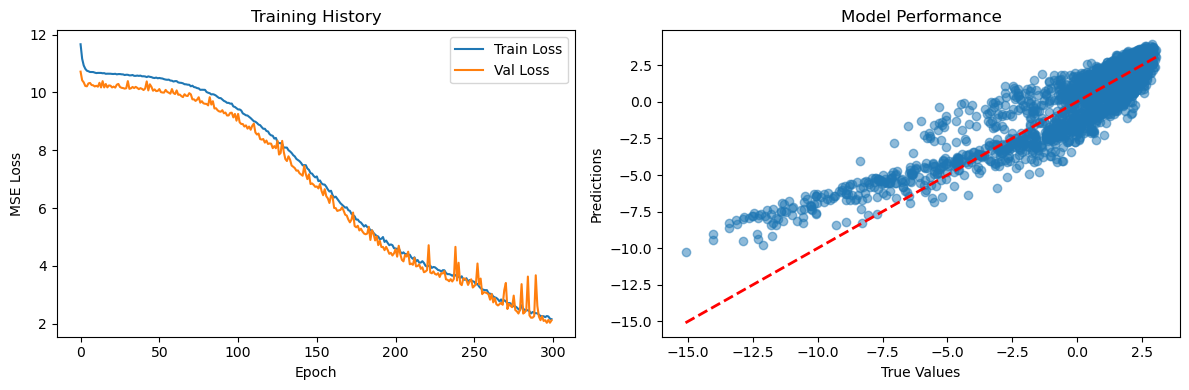

In [103]:
EPOCHS = 300
train_dataset, val_dataset, train_loader, val_loader, feature_cols, X_val, y_val, X_train, y_train = load_data(scaling=False)

model = SurrogateModel(input_dim=len(feature_cols), hidden_dims=[64])
print(f"Training model with {len(feature_cols)} input features...")
train_losses, val_losses = train_model(model, train_loader, val_loader, learning_rate=1E-3)

# 6. Evaluation
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_val.values)
    predictions = model(X_test).numpy().flatten()

plot_results(train_losses, val_losses, predictions)

It is not very good but it already shows potential. What happens if we scale the inputs with the same network architecture?

Train T range: 500.052567768837 to 1499.8862778372106
Val T range: 500.8647911688058 to 1498.833605698965
0.0011019322451042105 0.0003558383448045687
0.0010925433530073782 0.0003484421744351687
Training model with 4 input features...
Epoch [20/100] - Train Loss: 0.000901, Val Loss: 0.001161
Epoch [40/100] - Train Loss: 0.000670, Val Loss: 0.000500
Epoch [60/100] - Train Loss: 0.000518, Val Loss: 0.000423
Epoch [80/100] - Train Loss: 0.000505, Val Loss: 0.000355
Epoch [100/100] - Train Loss: 0.000521, Val Loss: 0.000471


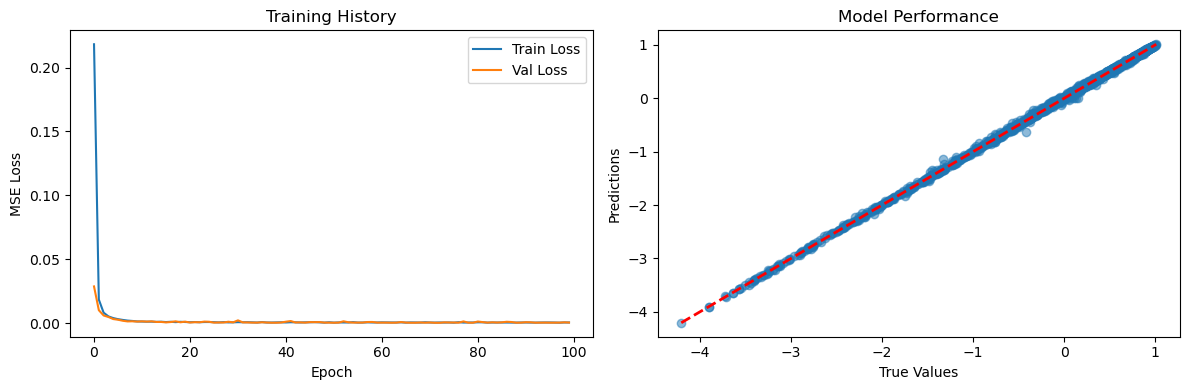

In [106]:
EPOCHS = 100
train_dataset, val_dataset, train_loader, val_loader, feature_cols, X_val, y_val, X_train, y_train = load_data(scaling=True)
model = SurrogateModel(input_dim=len(feature_cols), hidden_dims=[64])
print(f"Training model with {len(feature_cols)} input features...")
train_losses, val_losses = train_model(model, train_loader, val_loader)

# 6. Evaluation
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_val.values)
    predictions = model(X_test).numpy().flatten()

plot_results(train_losses, val_losses, predictions)

In [107]:
%%timeit
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_val.values)
    predictions = model(X_test).numpy().flatten()

325 μs ± 12.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [108]:
from time import time
start_time = time()
for _ in range(1000):
    model.eval()
    with torch.no_grad():
        X_test = torch.FloatTensor(X_val.values)
        predictions = model(X_test).numpy().flatten()
end_time = time()
print((end_time - start_time), 'ms')

0.3365457057952881 ms


### Conclusion for this section
- 1 hidden layer with only 64 neurons provides lower MSE and faster training **if scaled**. This is standard practice.
- This simple FFNN with only 64 hidden layers produces highly accurate results
- Execution times reduce from ~24 ms to 0.34 ms, speed up factor of about 70x. 

# Error study
The objective of this part is to better understand the error distributions within the microkinetic landscape

In [109]:
def postprocessing(predictions, y_val):
    plt.figure()
    plt.hist(np.exp(predictions) - np.exp(y_val), bins=30)
    plt.xlabel('error, mol/m2/s')
    plt.show()

    plt.figure()
    plt.plot(np.exp(predictions), np.exp(y_val), '.')
    plt.xlabel(r'predicted N$_2$O rate, mol/m2/s')
    plt.ylabel(r'IDA solved N$_2$O rate, mol/m2/s')
    plt.show()
    

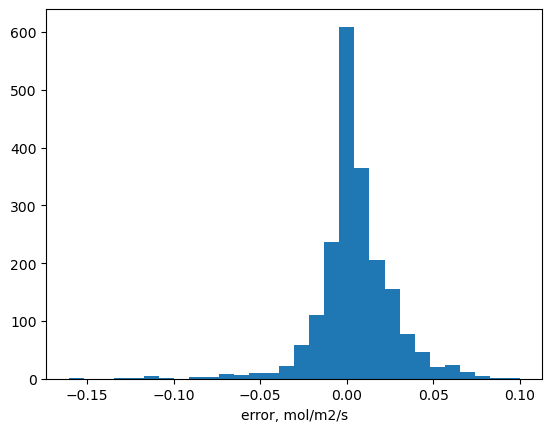

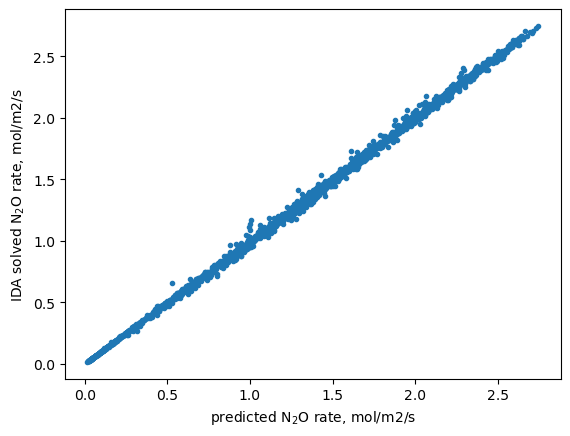

In [110]:
postprocessing(predictions, y_val)

We should consider more accurate ways to model this. We have a few options. More neurons, more hidden layers, different activation functions. 
One of the problems to be addressed is that the error rates are larger for larger reaction rates. One of the observations pointed out in my thesis is that using log scaling on the rates is effectively doing a proportional error evaluation in the training phase, meaning that errors are treated equally on the low end of the spectrum as compared to the higher end of the reaction rate spectrum. This happens due to the properties of logarithms. Using MSE penalizes larger % deviations compared to smaller ones, which is in line with our objectives.

## Network architecture study
First we'll focus on ReLU activation functions

Train T range: 500.052567768837 to 1499.8862778372106
Val T range: 500.8647911688058 to 1498.833605698965
0.0011019322451042105 0.0003558383448045687
0.0010925433530073782 0.0003484421744351687
Training model with 4 input features...
Epoch [20/100] - Train Loss: 0.000768, Val Loss: 0.000730
Epoch [40/100] - Train Loss: 0.000408, Val Loss: 0.000320
Epoch [60/100] - Train Loss: 0.000327, Val Loss: 0.000297
Epoch [80/100] - Train Loss: 0.000274, Val Loss: 0.000320
Epoch [100/100] - Train Loss: 0.000284, Val Loss: 0.001232


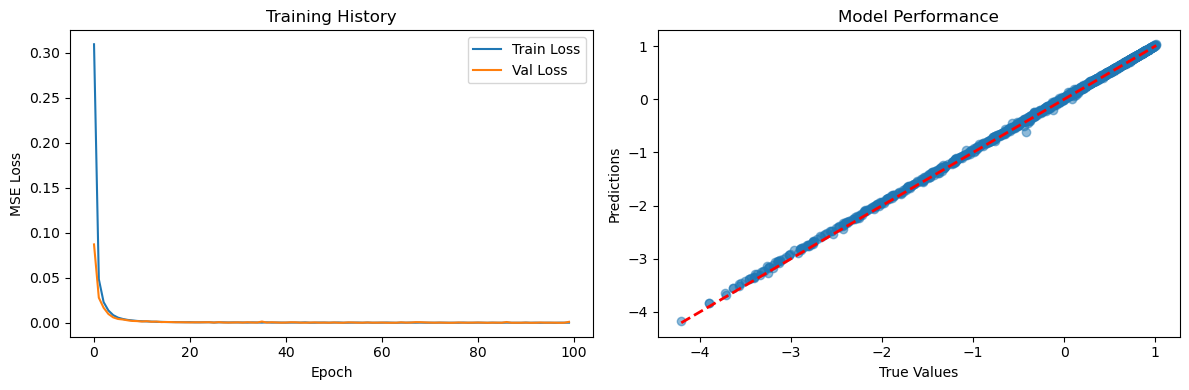

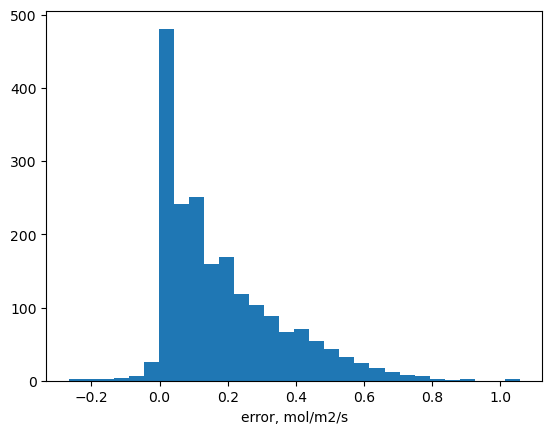

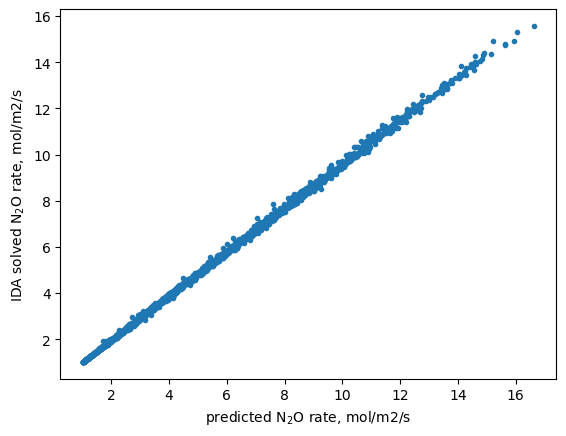

In [113]:
# Initialize and train model
train_dataset, val_dataset, train_loader, val_loader, feature_cols, X_val, y_val, X_train, y_train = load_data(scaling=True)
model = SurrogateModel(input_dim=len(feature_cols), hidden_dims=[256], activation='Relu')
print(f"Training model with {len(feature_cols)} input features...")
train_losses, val_losses = train_model(model, train_loader, val_loader, learning_rate=3e-4)

# 6. Evaluation
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_val.values)
    predictions = model(X_test).numpy().flatten()

plot_results(train_losses, val_losses, predictions)
postprocessing(np.exp(predictions), np.exp(y_val))

Train T range: 500.052567768837 to 1499.8862778372106
Val T range: 500.8647911688058 to 1498.833605698965
0.0011019322451042105 0.0003558383448045687
0.0010925433530073782 0.0003484421744351687
Training model with 4 input features...
Epoch [20/100] - Train Loss: 0.001086, Val Loss: 0.000481
Epoch [40/100] - Train Loss: 0.000258, Val Loss: 0.000187
Epoch [60/100] - Train Loss: 0.000142, Val Loss: 0.000128
Epoch [80/100] - Train Loss: 0.000425, Val Loss: 0.000393
Epoch [100/100] - Train Loss: 0.000748, Val Loss: 0.000086


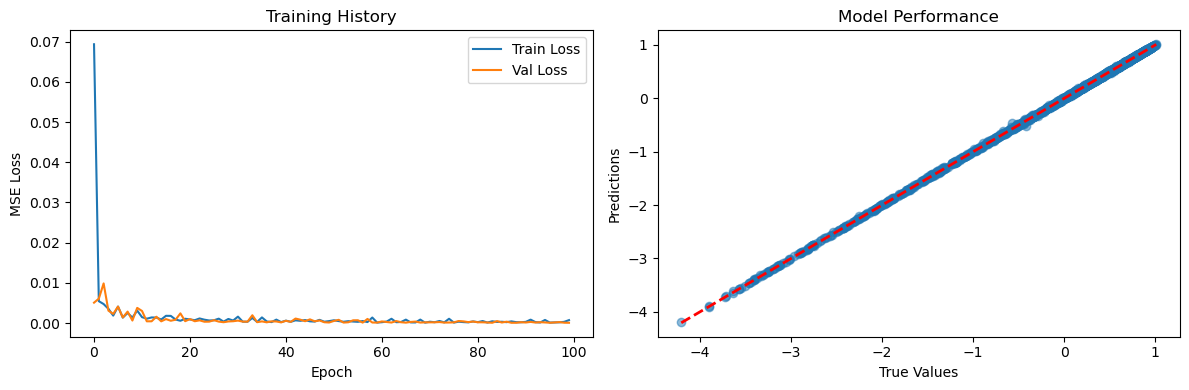

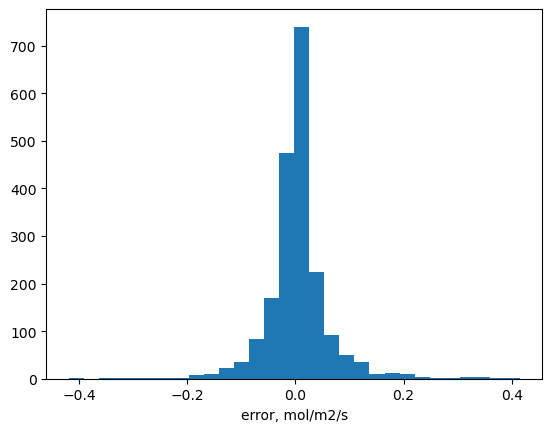

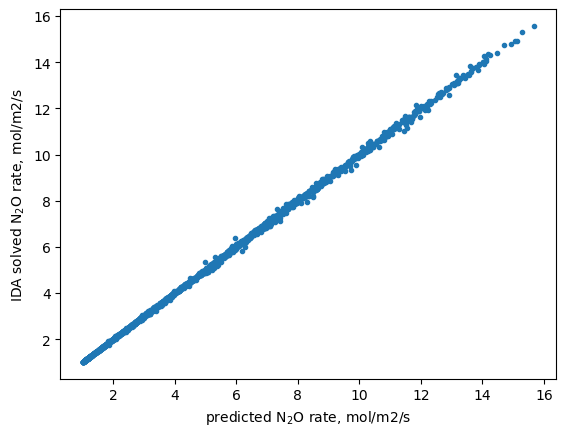

In [114]:
train_dataset, val_dataset, train_loader, val_loader, feature_cols, X_val, y_val, X_train, y_train = load_data(scaling=True)
model = SurrogateModel(input_dim=len(feature_cols), hidden_dims=[128, 128])
print(f"Training model with {len(feature_cols)} input features...")
train_losses, val_losses = train_model(model, train_loader, val_loader)

# 6. Evaluation
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_val.values)
    predictions = model(X_test).numpy().flatten()

plot_results(train_losses, val_losses, predictions)
postprocessing(np.exp(predictions), np.exp(y_val))

Train T range: 500.052567768837 to 1499.8862778372106
Val T range: 500.8647911688058 to 1498.833605698965
0.0011019322451042105 0.0003558383448045687
0.0010925433530073782 0.0003484421744351687
Training model with 4 input features...
Epoch [20/100] - Train Loss: 0.002822, Val Loss: 0.000508
Epoch [40/100] - Train Loss: 0.001987, Val Loss: 0.000375
Epoch [60/100] - Train Loss: 0.001236, Val Loss: 0.001239
Epoch [80/100] - Train Loss: 0.000360, Val Loss: 0.000714
Epoch [100/100] - Train Loss: 0.000268, Val Loss: 0.000139


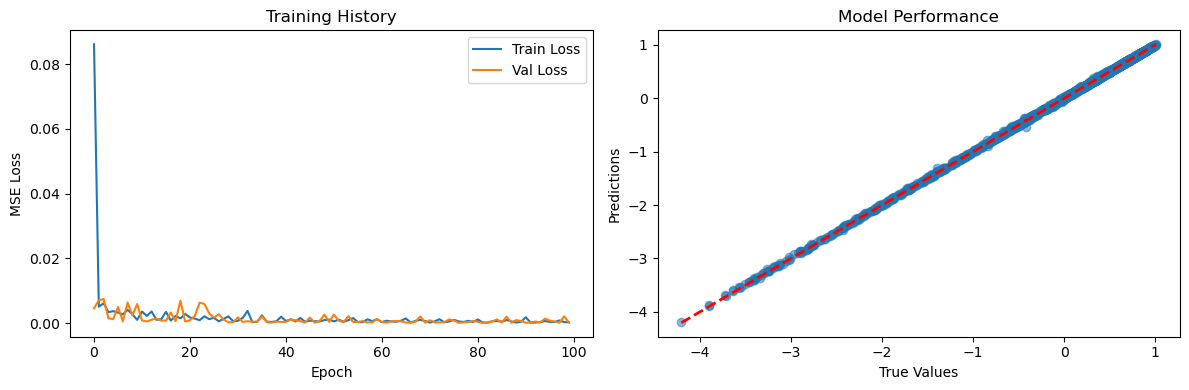

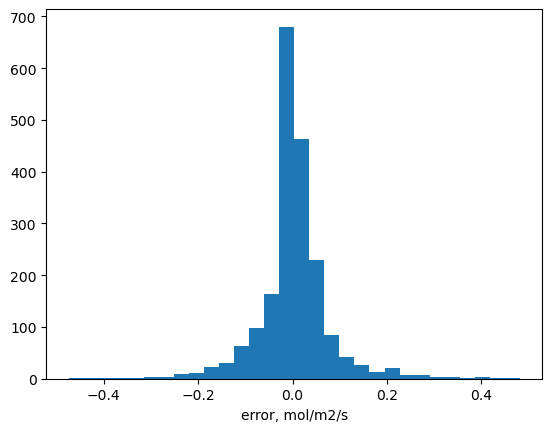

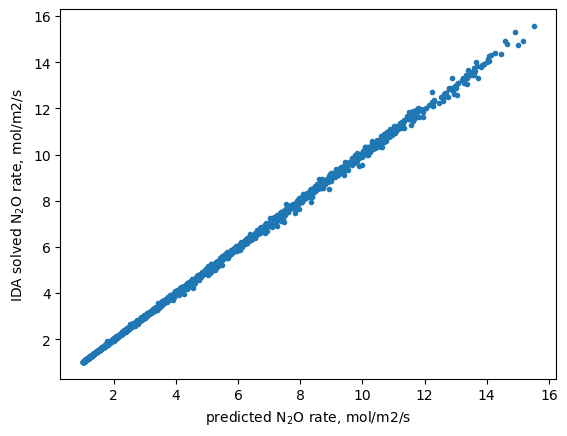

In [115]:
train_dataset, val_dataset, train_loader, val_loader, feature_cols, X_val, y_val, X_train, y_train = load_data(scaling=True)
model = SurrogateModel(input_dim=len(feature_cols), hidden_dims=[64, 64, 64, 64])
print(f"Training model with {len(feature_cols)} input features...")
train_losses, val_losses = train_model(model, train_loader, val_loader)

# 6. Evaluation
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_val.values)
    predictions = model(X_test).numpy().flatten()

plot_results(train_losses, val_losses, predictions)
postprocessing(np.exp(predictions), np.exp(y_val))

They all provide similar results. We are going to try a different activation function

## SiLU activation function

Train T range: 500.052567768837 to 1499.8862778372106
Val T range: 500.8647911688058 to 1498.833605698965
0.0011019322451042105 0.0003558383448045687
0.0010925433530073782 0.0003484421744351687
Training model with 4 input features...
Epoch [20/100] - Train Loss: 0.006149, Val Loss: 0.006551
Epoch [40/100] - Train Loss: 0.003375, Val Loss: 0.003193
Epoch [60/100] - Train Loss: 0.002295, Val Loss: 0.001812
Epoch [80/100] - Train Loss: 0.001725, Val Loss: 0.001639
Epoch [100/100] - Train Loss: 0.001500, Val Loss: 0.001393


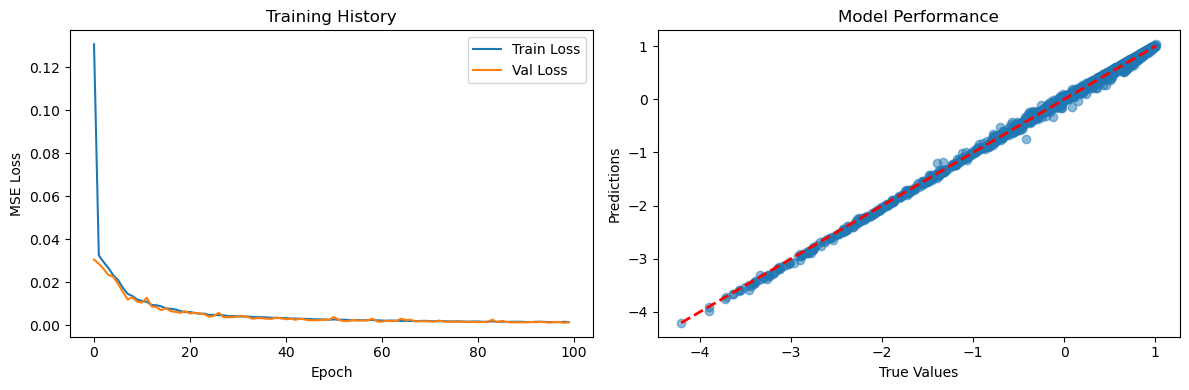

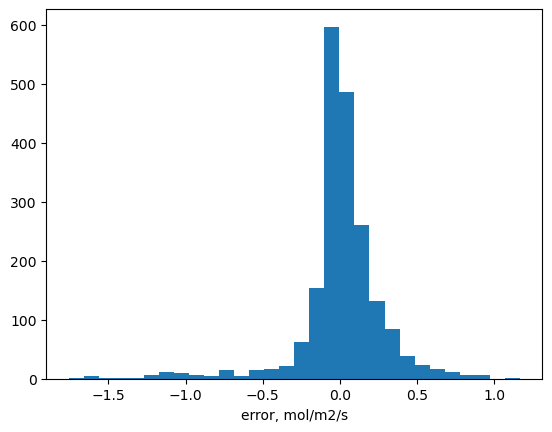

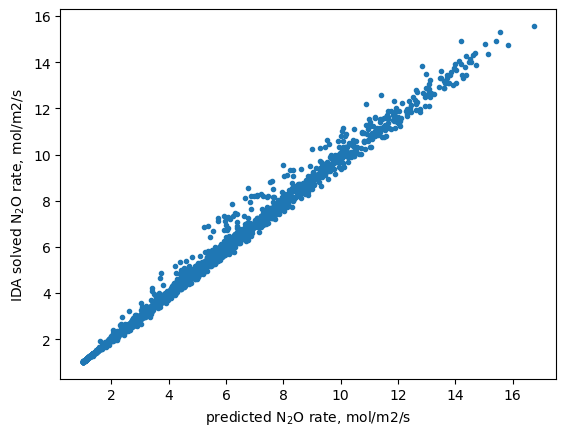

In [116]:
EPOCHS=100
train_dataset, val_dataset, train_loader, val_loader, feature_cols, X_val, y_val, X_train, y_train = load_data(scaling=True)
model = SurrogateModel(input_dim=len(feature_cols), hidden_dims=[256], activation='SiLU')
print(f"Training model with {len(feature_cols)} input features...")
train_losses, val_losses = train_model(model, train_loader, val_loader)

# 6. Evaluation
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_val.values)
    predictions = model(X_test).numpy().flatten()

plot_results(train_losses, val_losses, predictions)
postprocessing(np.exp(predictions), np.exp(y_val))

Train T range: 500.052567768837 to 1499.8862778372106
Val T range: 500.8647911688058 to 1498.833605698965
0.0011019322451042105 0.0003558383448045687
0.0010925433530073782 0.0003484421744351687
Training model with 4 input features...
Epoch [20/100] - Train Loss: 0.001028, Val Loss: 0.000445
Epoch [40/100] - Train Loss: 0.000409, Val Loss: 0.000383
Epoch [60/100] - Train Loss: 0.000668, Val Loss: 0.000410
Epoch [80/100] - Train Loss: 0.000302, Val Loss: 0.000330
Epoch [100/100] - Train Loss: 0.000469, Val Loss: 0.000180


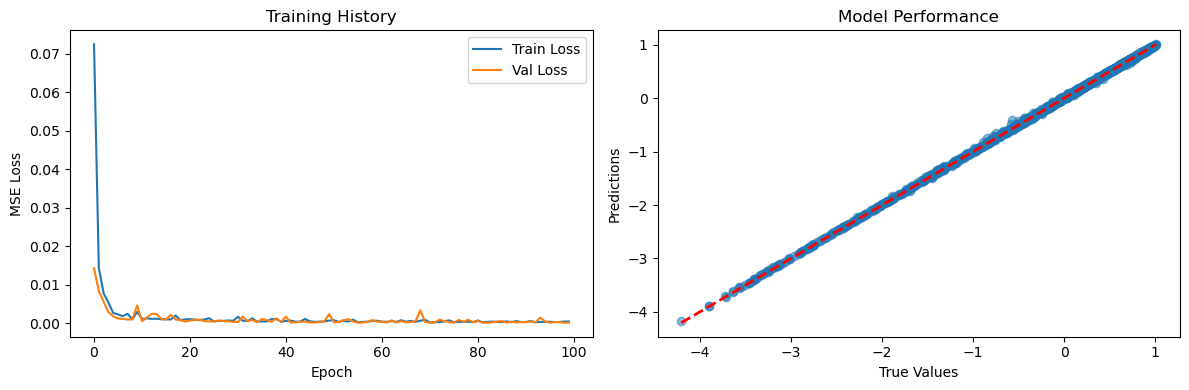

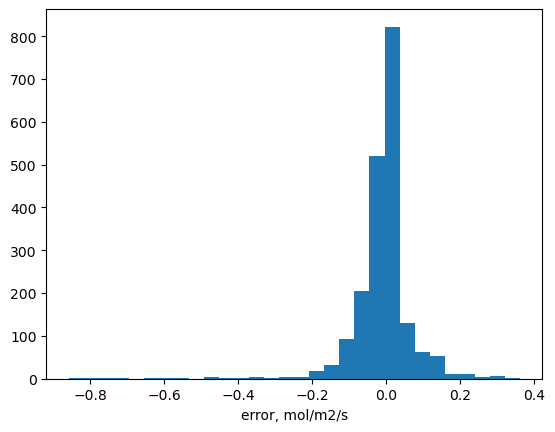

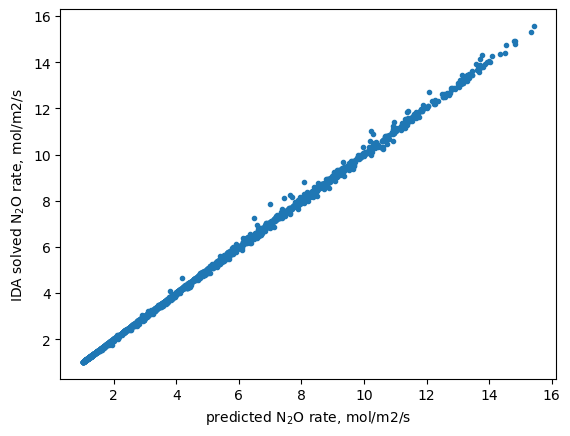

In [118]:
EPOCHS=100
train_dataset, val_dataset, train_loader, val_loader, feature_cols, X_val, y_val, X_train, y_train = load_data(scaling=True)
model = SurrogateModel(input_dim=len(feature_cols), hidden_dims=[128,128], activation='SiLU')
print(f"Training model with {len(feature_cols)} input features...")
train_losses, val_losses = train_model(model, train_loader, val_loader)

# 6. Evaluation
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_val.values)
    predictions = model(X_test).numpy().flatten()

plot_results(train_losses, val_losses, predictions)
postprocessing(np.exp(predictions), np.exp(y_val))

Train T range: 500.052567768837 to 1499.8862778372106
Val T range: 500.8647911688058 to 1498.833605698965
0.0011019322451042105 0.0003558383448045687
0.0010925433530073782 0.0003484421744351687
Training model with 4 input features...
Epoch [20/100] - Train Loss: 0.000938, Val Loss: 0.000461
Epoch [40/100] - Train Loss: 0.001628, Val Loss: 0.001242
Epoch [60/100] - Train Loss: 0.000866, Val Loss: 0.000225
Epoch [80/100] - Train Loss: 0.000355, Val Loss: 0.001173
Epoch [100/100] - Train Loss: 0.000106, Val Loss: 0.000063


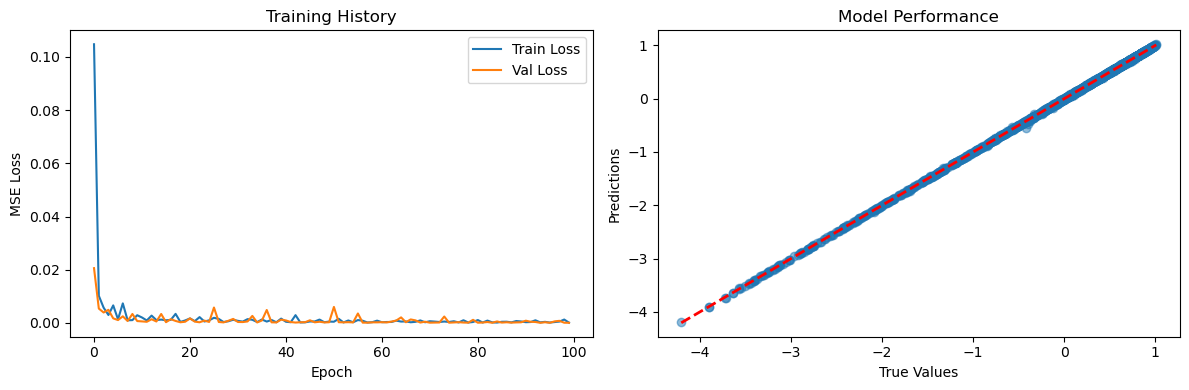

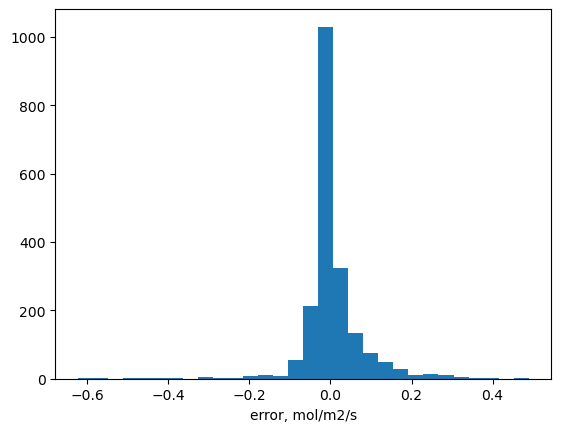

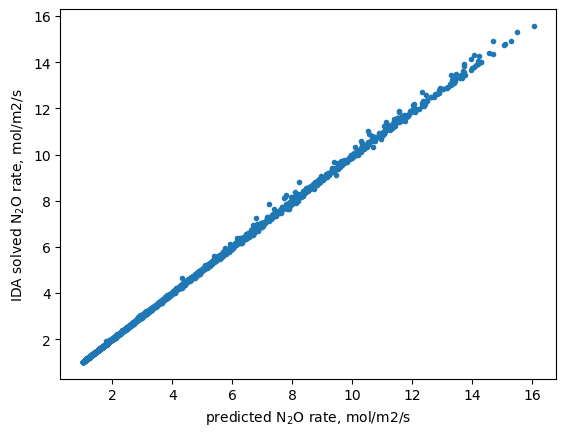

In [119]:
EPOCHS=100
train_dataset, val_dataset, train_loader, val_loader, feature_cols, X_val, y_val, X_train, y_train = load_data(scaling=True)
model = SurrogateModel(input_dim=len(feature_cols), hidden_dims=[64,64,64,64], activation='SiLU')
print(f"Training model with {len(feature_cols)} input features...")
train_losses, val_losses = train_model(model, train_loader, val_loader)

# 6. Evaluation
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_val.values)
    predictions = model(X_test).numpy().flatten()

plot_results(train_losses, val_losses, predictions)
postprocessing(np.exp(predictions), np.exp(y_val))

# Extrapolation to higher temperatures
This shows that this networks is good at doing interpolation which was our main objective, but it fails catastrophically at extrapolation. This is an indication that the network is not learning the physical phenomena of the problem.

Train T range: 500.052567768837 to 1499.8862778372106
Val T range: 500.8647911688058 to 1498.833605698965
0.0014714613874432618 0.00025243782502908747
0.0010925433530073782 0.0003484421744351687
Training model with 4 input features...
Epoch [20/100] - Train Loss: 0.001185, Val Loss: 0.010853
Epoch [40/100] - Train Loss: 0.000294, Val Loss: 0.008056
Epoch [60/100] - Train Loss: 0.000133, Val Loss: 0.008034
Epoch [80/100] - Train Loss: 0.000529, Val Loss: 0.008235
Epoch [100/100] - Train Loss: 0.000761, Val Loss: 0.008848


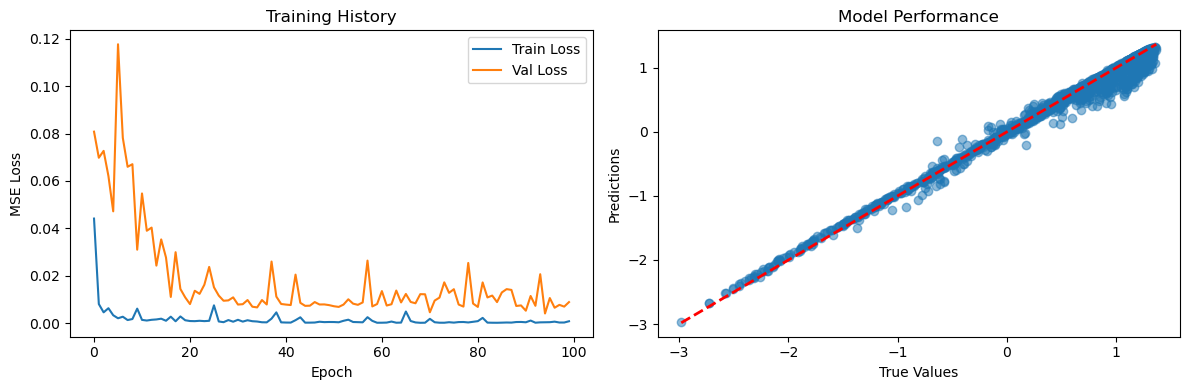

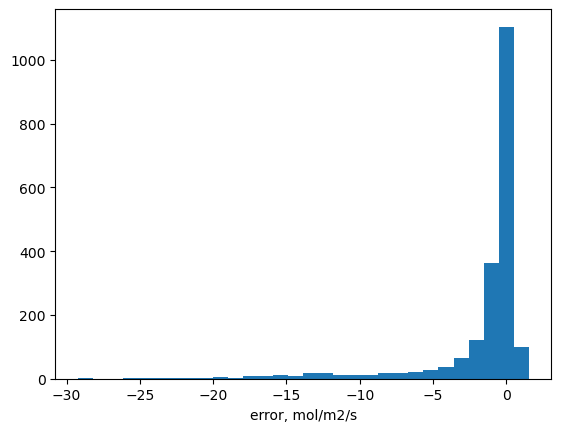

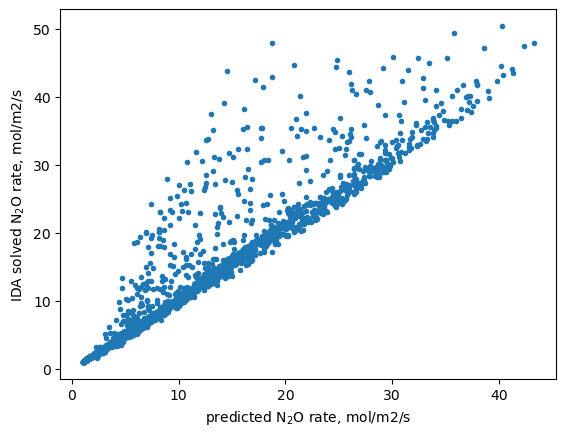

In [122]:
EPOCHS=100
train_dataset, val_dataset, train_loader, val_loader, feature_cols, X_val, y_val, X_train, y_train = load_data(scaling=True, max_train_temp=900)
model = SurrogateModel(input_dim=len(feature_cols), hidden_dims=[256,256], activation='SiLU')
print(f"Training model with {len(feature_cols)} input features...")
train_losses, val_losses = train_model(model, train_loader, val_loader)

# 6. Evaluation
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_val.values)
    predictions = model(X_test).numpy().flatten()

plot_results(train_losses, val_losses, predictions)
postprocessing(np.exp(predictions), np.exp(y_val))

Train T range: 500.052567768837 to 1499.8862778372106
Val T range: 500.8647911688058 to 1498.833605698965
0.0014714613874432618 0.00025243782502908747
0.0010925433530073782 0.0003484421744351687
Training model with 4 input features...
Epoch [20/300] - Train Loss: 0.000385, Val Loss: 0.019125
Epoch [40/300] - Train Loss: 0.000918, Val Loss: 0.018930
Epoch [60/300] - Train Loss: 0.000705, Val Loss: 0.006405
Epoch [80/300] - Train Loss: 0.000323, Val Loss: 0.007500
Epoch [100/300] - Train Loss: 0.000165, Val Loss: 0.005878
Epoch [120/300] - Train Loss: 0.001144, Val Loss: 0.006657
Epoch [140/300] - Train Loss: 0.002394, Val Loss: 0.017954
Epoch [160/300] - Train Loss: 0.000209, Val Loss: 0.005715
Epoch [180/300] - Train Loss: 0.000489, Val Loss: 0.006240
Epoch [200/300] - Train Loss: 0.000128, Val Loss: 0.006246
Epoch [220/300] - Train Loss: 0.000228, Val Loss: 0.004015
Epoch [240/300] - Train Loss: 0.000415, Val Loss: 0.005232
Epoch [260/300] - Train Loss: 0.000133, Val Loss: 0.004148
Ep

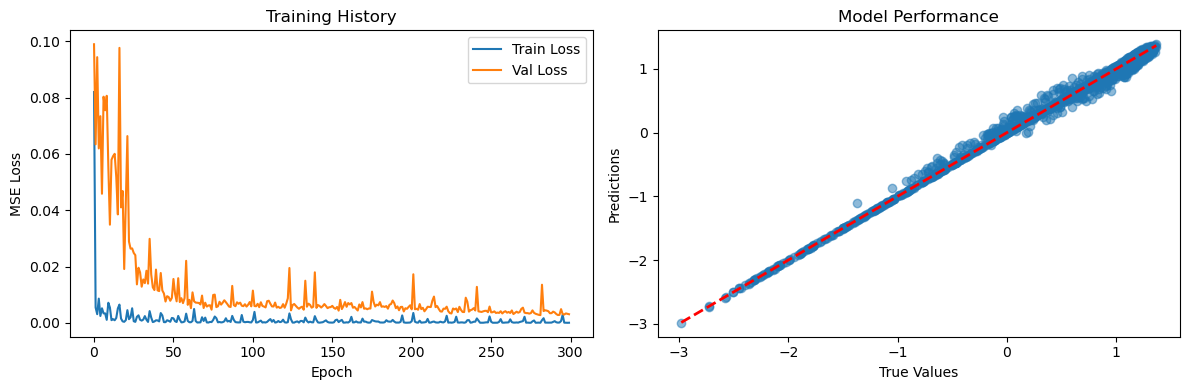

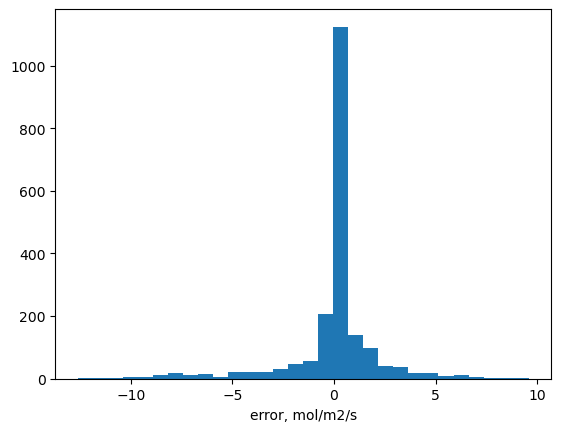

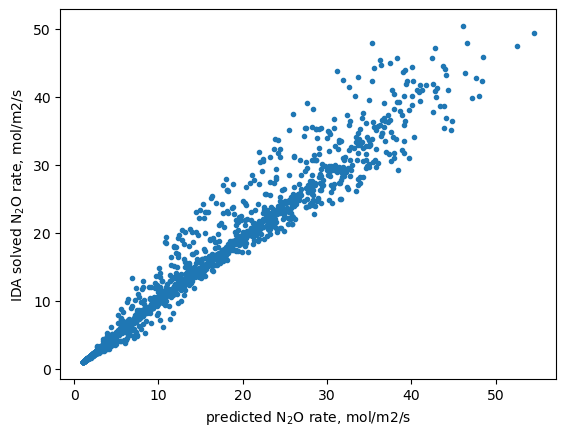

In [124]:
EPOCHS=300
train_dataset, val_dataset, train_loader, val_loader, feature_cols, X_val, y_val, X_train, y_train = load_data(scaling=True, max_train_temp=900)
model = SurrogateModel(input_dim=len(feature_cols), hidden_dims=[128,128,128,128], activation='SiLU')
print(f"Training model with {len(feature_cols)} input features...")
train_losses, val_losses = train_model(model, train_loader, val_loader)

# 6. Evaluation
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_val.values)
    predictions = model(X_test).numpy().flatten()

plot_results(train_losses, val_losses, predictions)
postprocessing(np.exp(predictions), np.exp(y_val))